In [1]:
import sys
sys.path.append("ml")

In [2]:
import time
import json
import glob
import random
import numpy as np
import torch
import make_dataset2 as make_dataset

In [3]:
random.seed(1234)

In [4]:
device = "cpu"

In [5]:
class EWMA:
    def __init__(self, alpha=0.02):
        self.alpha = alpha
        self.value = None

    def apply(self, x):
        self.value = x if self.value is None else (1 - self.alpha) * self.value + self.alpha * x

In [6]:
%%time
dm_train = np.load("dm_train.npz")
dm_features = dm_train["features"]
dm_policy = dm_train["policy_to"]
dm_value = dm_train["value"]
dm_val_train = np.load("dm_val.npz")
dm_val_features = dm_val_train["features"]
dm_val_policy = dm_val_train["policy_to"]
dm_val_value = dm_val_train["value"]

CPU times: user 6.06 s, sys: 344 ms, total: 6.4 s
Wall time: 6.4 s


In [7]:
reshaped = dm_features.reshape(-1, 15, 8, 8)
is_white_turn = reshaped[:, -2, 0, 0]
is_duck_move = reshaped[:, -1, 0, 0]
dm_features = reshaped[:, :-2].reshape(-1, 13 * 8 * 8)

reshaped = dm_val_features.reshape(-1, 15, 8, 8)
val_is_white_turn = reshaped[:, -2, 0, 0]
val_is_duck_move = reshaped[:, -1, 0, 0]
dm_val_features = reshaped[:, :-2].reshape(-1, 13 * 8 * 8)

In [8]:
dm_val_features = torch.tensor(dm_val_features, dtype=torch.float32, device=device)
dm_val_policy = torch.tensor(dm_val_policy, dtype=torch.int64, device=device)
dm_val_value = torch.tensor(dm_val_value, dtype=torch.float32, device=device)

In [9]:
print(dm_features.shape)
print(dm_policy.shape)
print(dm_value.shape)
print(dm_val_features.shape)
print(dm_val_policy.shape)
print(dm_val_value.shape)

(5772379, 832)
(5772379,)
(5772379, 1)
torch.Size([21997, 832])
torch.Size([21997])
torch.Size([21997, 1])


In [10]:
feature_count = dm_features.shape[1]

class MultiModel(torch.nn.Module):
    FEATS = 48

    def __init__(self):
        super().__init__()
        self.main_embed = torch.nn.Linear(feature_count, self.FEATS)
        self.relu = torch.nn.ReLU()
        self.white_main = torch.nn.Linear(self.FEATS, 64 + 1)
        self.black_main = torch.nn.Linear(self.FEATS, 64 + 1)
        self.white_duck = torch.nn.Linear(self.FEATS, 64 + 1)
        self.black_duck = torch.nn.Linear(self.FEATS, 64 + 1)

    def forward(self, inputs, which_model):
        embedding = self.main_embed(inputs)
        embedding = self.relu(embedding)
        white_main = self.white_main(embedding)
        black_main = self.black_main(embedding)
        white_duck = self.white_duck(embedding)
        black_duck = self.black_duck(embedding)
        data = torch.stack([white_main, black_main, white_duck, black_duck])
        return data[which_model, torch.arange(len(which_model))]

model = MultiModel()

print("Parameters:", sum(np.product(t.shape) for t in model.parameters()))

Parameters: 52724


In [11]:
cross_en = torch.nn.CrossEntropyLoss()
mse_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
policy_loss_ewma = EWMA()
value_loss_ewma = EWMA()

In [14]:
for g in optimizer.param_groups:
    g['lr'] = 2e-5

In [15]:
dm_val_which_model = 2 * val_is_duck_move + (1 - val_is_white_turn)

def make_batch(batch_size):
    indices = np.random.randint(0, len(dm_features), size=batch_size)
    features = torch.tensor(dm_features[indices], dtype=torch.float32, device=device)
    policy = torch.tensor(dm_policy[indices], dtype=torch.int64, device=device)
    value = torch.tensor(dm_value[indices], dtype=torch.float32, device=device)
    which_model = torch.tensor(
        2 * is_duck_move[indices] + (1 - is_white_turn[indices]),
        dtype=torch.int64,
        device=device,
    )
    return features, policy, value, which_model

start_time = time.time()
for i in range(1_000_000):
    optimizer.zero_grad()
    features, target_policy, target_value, which_model = make_batch(512)
    outputs = model(features, which_model)
    policy_output = outputs[:, :64]
    value_output = outputs[:, 64:]
    policy_loss = cross_en(policy_output, target_policy)
    value_loss = mse_func(value_output, target_value)
    loss = policy_loss + value_loss
    loss.backward()
    optimizer.step()
    policy_loss_ewma.apply(policy_loss.item())
    value_loss_ewma.apply(value_loss.item())

    if i % 2500 == 0:
        # Compute the accuracy.
        outputs = model(dm_val_features, dm_val_which_model)
        val_policy_output = outputs[:, :64]
        val_value_output = outputs[:, 64:]

        correct = val_policy_output.argmax(axis=-1) == dm_val_policy
        accuracy = correct.mean(dtype=torch.float32).item()
        print("(%7.1f) [%7i] loss = %.4f (policy = %.4f  value = %0.4f) (val acc: %5.1f%%)" % (
            time.time() - start_time,
            i,
            policy_loss_ewma.value + value_loss_ewma.value,
            policy_loss_ewma.value,
            value_loss_ewma.value,
            100 * accuracy,
        ))

(    0.0) [      0] loss = 3.5305 (policy = 2.9413  value = 0.5892) (val acc:  23.9%)
(    4.8) [   2500] loss = 3.5233 (policy = 2.9340  value = 0.5892) (val acc:  24.2%)
(    9.4) [   5000] loss = 3.5350 (policy = 2.9476  value = 0.5874) (val acc:  24.1%)
(   14.0) [   7500] loss = 3.5370 (policy = 2.9509  value = 0.5861) (val acc:  24.2%)
(   18.6) [  10000] loss = 3.5358 (policy = 2.9475  value = 0.5883) (val acc:  24.0%)
(   23.0) [  12500] loss = 3.5197 (policy = 2.9314  value = 0.5883) (val acc:  24.1%)
(   27.7) [  15000] loss = 3.5345 (policy = 2.9447  value = 0.5898) (val acc:  24.1%)
(   32.2) [  17500] loss = 3.5295 (policy = 2.9439  value = 0.5856) (val acc:  24.0%)
(   36.8) [  20000] loss = 3.5314 (policy = 2.9444  value = 0.5870) (val acc:  24.3%)
(   41.5) [  22500] loss = 3.5389 (policy = 2.9518  value = 0.5870) (val acc:  24.2%)
(   46.6) [  25000] loss = 3.5366 (policy = 2.9541  value = 0.5825) (val acc:  24.1%)
(   51.1) [  27500] loss = 3.5364 (policy = 2.9481  va

KeyboardInterrupt: 

In [16]:
torch.save(model.state_dict(), "multi-model-feat48-001.pt")

In [26]:
#torch.save(model.state_dict(), "move_model.pt")

In [29]:
for k, v in model.state_dict().items():
    print(k, v.shape)

0.weight torch.Size([32, 1472])
0.bias torch.Size([32])
2.weight torch.Size([64, 32])
2.bias torch.Size([64])


In [32]:
W = model.state_dict()["0.weight"].detach().cpu().numpy()

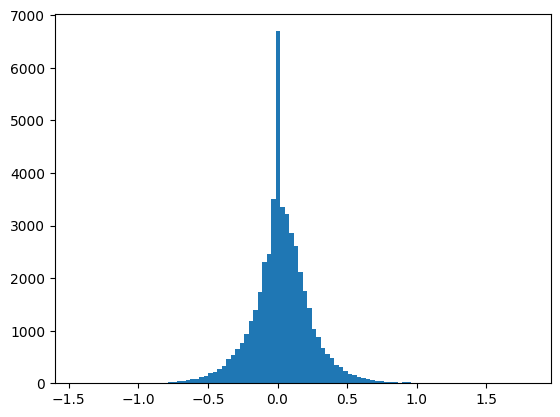

In [38]:
_ = plt.hist(W.flatten(), bins=100)

In [40]:
np.abs(W).max()

1.8015668

In [57]:
Wi = (W * 1000).astype(np.int32)

In [59]:
Wi

array([[   2,    7,    0, ..., -625, -385, -311],
       [ -14,   -7,  -13, ...,  326,   56, -207],
       [  -5,   17,  -10, ..., -622, -306, -556],
       ...,
       [   6,    3,  -13, ...,  -70,  -71, -163],
       [   6,  -10,    6, ..., -414, -375, -323],
       [  13,  -17,  -16, ..., -288,   17,  -83]], dtype=int32)

In [30]:
batch_size = 30
cases = 4
features = 64

# Generate some fake data.
data = torch.tensor(np.random.randn(cases, batch_size, features))
idx = torch.tensor(np.random.randint(low=0, high=cases, size=batch_size))

# Index into the data of shape [batch_size, cases, features], getting a result of shape [batch_size, features].
# This is the same as:
#   result = np.zeros((batch_size, features))
#   for i in range(batch_size):
#       result[i] = data[i, idx[i]]
result = data[idx, torch.arange(batch_size)]


In [31]:
result.shape

torch.Size([30, 64])

In [33]:
idx

tensor([3, 1, 2, 1, 1, 1, 0, 1, 0, 3, 1, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 3, 3, 3,
        1, 1, 1, 3, 0, 1])

In [36]:
result[0] == data[3, 0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])